In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify

In [5]:
# A Dictionary Hyperparameters  

hp = {}
hp['image_size'] = 200
hp['num_channels'] = 3
hp['patch_size'] = 25
hp['num_patches'] = (hp['image_size']**2 / hp['patch_size']**2)
hp['flat_patches_shape'] = (int(hp['num_patches']), hp['patch_size']*hp['patch_size']*hp['num_channels'])

hp['batch_size'] = 32
hp['lr'] = 1e-4
hp['num_epochs'] = 500
hp['num_classes'] = 5
hp['class_name'] = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
import tensorflow as tf

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, '*', '*.jpg')))
    print(int(len(images)))
    split_size = int(len(images)* split)
    #print(split_size)
    train_x, test_x = train_test_split(images, test_size=0.1, random_state = 42)
    print(int(len(train_x)), int(len(test_x)))
    return train_x, test_x

In [32]:
import matplotlib.pyplot as plt
def process_image_label(path):
    #path = path.decode('utf-8')
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp['image_size'], hp['image_size']))
    image = image/255.0
    #print(image.shape)
    
    # Preprocessing to patches 
    patch_shape = (hp['patch_size'], hp['patch_size'], hp['num_channels'])
    patches = patchify(image, patch_shape, hp['patch_size'])
    
    #print(hp['flat_patches_shape'])
    
    patches_r = np.reshape(patches, hp['flat_patches_shape'])
    patches_r = patches_r.astype(np.float32)

    
    patches = np.reshape(patches, (64, 25, 25, 3))
    n = 8
    plt.figure(figsize=(4, 4))
    for i in range(64):
        #cv2.imwrite(f'files/{i}.png' ,patches[i])
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patches[i], (hp['patch_size'], hp['patch_size'], 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")
        
    #patches_r = patches_r.astype(np.float32)
    
    # Label
    print(path)
    #path = str(path)
    #class_name = []
    
    '''this is unbelieveable https://stackoverflow.com/questions/3167154/how-to-split-a-dos-path-into-its-components-in-python'''
    
    
    class_name = path.split(os.sep)[-2]
    #print(class_name)
    class_idx = hp['class_name'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    print(class_name, class_idx)
    
    return patches_r, class_idx
    
    
    

In [33]:
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp['num_classes'])
    
    patches.set_shape(hp['flat_patches_shape'])
    labels.set_shape(hp['num_classes'])
    
    return patches, labels

In [34]:
def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds

3670
3303 367
C:\Users\DCL\Image-Classification-using-Vision-Transformer-ViT-\flower_photos\daisy\7191221492_610035de7c_m.jpg
daisy 0
ok


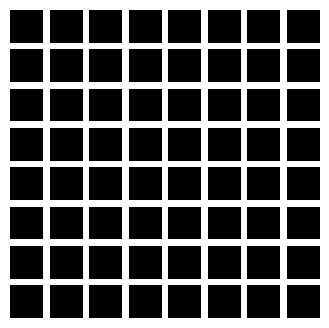

In [40]:
if __name__ == '__main__':
    # Seeding
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Directory for storing files
    create_dir('files')
    
    # paths
    dataset_path = r'C:\Users\DCL\Image-Classification-using-Vision-Transformer-ViT-\flower_photos'
    model_path = os.path.join('files', 'model.h5')
    csv_path = os.path.join('files', 'log.csv')
    
    train_x, test_x = load_data(dataset_path)
    process_image_label(test_x[0])
    
    
    train_ds = tf_dataset(train_x, batch=hp['batch_size'])
    valid_ds = tf_dataset(test_x, batch=hp['batch_size'])
    print('ok')
    
    #for x, y in train_ds:
       # print(x.shape, y.shape)
       # break